# Segmentazione di edifici da immagini satellitari e classificazione del contesto urbano

*Progetto di Visione Artificiale e Riconoscimento 2024/2025*

- **Nome:** Pablo Sebastian
- **Cognome:** Vargas Grateron
- **Email:** pablo.vargasgrateron@studio.unibo.it

Questo progetto si concentra sulla segmentazione di edifici da immagini satellitari e sulla classificazione del contesto urbano. Utilizza tecniche di deep learning per analizzare immagini aeree e identificare edifici e altre strutture urbane.

Il dataset utilizzato è il dataset [Inria Aerial Image Labeling](https://project.inria.fr/aerialimagelabeling/), che contiene immagini aeree ad alta risoluzione e le relative maschere di segmentazione degli edifici.

> Assicurati di scaricare il dataset prima di eseguire il notebook e di avere al meno 50 GB di spazio libero su disco.

## Librerie e percorsi dei dataset

Il codice contenuto nelle seguenti celle importa le librerie necessarie e definisce i percorsi per i dataset utilizzati nel progetto.

> Assicurati di avere installato le librerie richieste contenute nel file `requirements.txt` prima di eseguire il notebook.

In [ ]:
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

Per la prossima cella, assicurati di avere i seguenti percorsi impostati correttamente:
- `path_dataset_dir`: percorso alla cartella principale dove sono memorizzati i dataset.
- `path_dataset`: percorso alla cartella contenente i dataset originali.
- `path_processed_dataset`: percorso alla cartella dove saranno memorizzati i dataset elaborati.

In [3]:
path_dataset_dir = Path("../../dataset")
path_dataset = path_dataset_dir / "original"
path_processed_dataset = path_dataset_dir / "processed"

path_train_dataset = path_dataset / "train"
path_test_dataset = path_dataset / "test"

path_train_dataset_processed = path_processed_dataset / "train"
path_test_dataset_processed = path_processed_dataset / "test"

## Preparazione del dataset

###  Divisione in segmenti

Per arricchire il dataset e migliorare le prestazioni del modello, le immagini e le maschere vengono suddivise in segmenti più piccoli. Questo processo consente di gestire meglio le immagini ad alta risoluzione e di aumentare la varietà dei dati di addestramento.

In [4]:
def extract_patches_from_folder(input_folder: Path, output_folder: Path, patch_size=500):
    os.makedirs(output_folder, exist_ok=True)
    image_files = list(input_folder.glob("*.tif")) + list(input_folder.glob("*.TIF")) + list(input_folder.glob("*.tiff"))
    
    count = 0
    for img_path in image_files:
        img = Image.open(img_path)
        width, height = img.size

        for top in range(0, height, patch_size):
            for left in range(0, width, patch_size):
                right = min(left + patch_size, width)
                bottom = min(top + patch_size, height)

                if right - left == patch_size and bottom - top == patch_size:
                    patch = img.crop((left, top, right, bottom))
                    patch_name = f"{img_path.stem}_x{left}_y{top}.tif"
                    patch.save(output_folder / patch_name)
                    count += 1

    print(f"Generati {count} patch da {input_folder.name} in {output_folder.name}")

Dato che il dataset contiene 360 immagini di dimensioni 5000x5000 pixel, la suddivisione in segmenti di 500x500 pixel dovrebbe generare 36.000 segmenti per ogni cartella.

> Per modificare la dimensione dei segmenti, puoi cambiare il valore della variabile `PATCH_SIZE` nella cella seguente.

> **Attenzione:** La prossima cella esegue un'operazione di preprocessing che potrebbe richiedere tempo a seconda della dimensione del dataset.

In [ ]:
PATCH_SIZE = 500

def has_images(folder: Path):
    return any(folder.glob("*.tif")) or any(folder.glob("*.TIF")) or any(folder.glob("*.tiff"))

if not has_images(path_train_dataset_processed / "images"):
    extract_patches_from_folder(path_train_dataset / "images", path_train_dataset_processed / "images", PATCH_SIZE)
else:
    print("Immagini elaborate del train già esistono.")

if not has_images(path_train_dataset_processed / "gt"):
    extract_patches_from_folder(path_train_dataset / "gt", path_train_dataset_processed / "gt", PATCH_SIZE)
else:
    print("Immagini GT elaborate del train già esistono.")

if not has_images(path_test_dataset_processed / "images"):
    extract_patches_from_folder(path_test_dataset / "images", path_test_dataset_processed / "images", PATCH_SIZE)
else:
    print("Immagini elaborate del test già esistono.")

Processed train images already exist.
Processed train gt already exist.
Processed train gt already exist.
Processed test images already exist.
Processed test images already exist.


Per controllare il corretto funzionamento del codice, puoi eseguire le celle seguenti per visualizzare le prime immagini del dataset originale e quelle elaborate.

In [10]:
def print_specific_image(folder: Path, filename: str):
    img_path = folder / filename
    if img_path.exists():
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f"{img_path.name}")
        plt.axis('off')
        plt.show()
    else:
        print(f"File {filename} not found in {folder}")

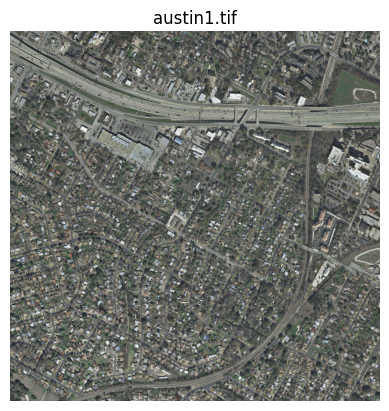

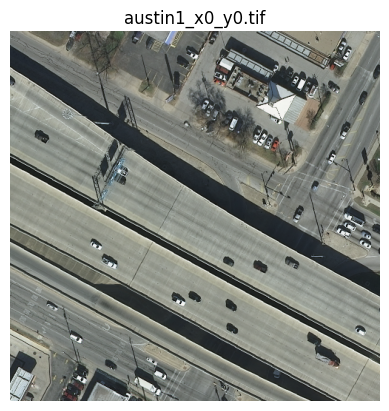

In [13]:
print_specific_image(path_train_dataset / "images", "austin1.tif")
print_specific_image(path_train_dataset_processed / "images", "austin1_x0_y0.tif")

## Training